# de novo indel occurences correlated with germline expression

[Gene4Denovo](http://www.genemed.tech/gene4denovo/) variants compared with expression data from  Xia et al. (https://doi.org/10.1016/j.cell.2019.12.015)


In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utils.utils import df_to_group_counts, get_id83_order
%matplotlib inline
sns.set_context('talk')

out_dir = "outputs/dnm_germline_expression"
os.makedirs(out_dir, exist_ok=True)

In [2]:
indel_df = pd.read_csv(
    "data/gene4denovo/gene4denovo_indels_with_germline_expression.csv",
    dtype={'chrom': str, 'pos': int})
indel_df.head()

chrom        pos  qual    ref       alt  n_alleles variant_type repeat_type  \
0     1  217847741   NaN   TAGG         T          2          Del     Perfect   
1     2  164875949   NaN  TTTTA         T          2          Del     Perfect   
2    11  106845486   NaN  CAGAG         C          2          Del     Perfect   
3     4   91938901   NaN     TC         T          2          Del   No repeat   
4    13   35751685   NaN      C  CGGTATCT          2          Ins   No repeat   

  repeat_unit  repeat_length  ... variant_length  cosmic_class transcribed  \
0         AGG              9  ...              3     3:Del:R:2        True   
1        TTTA              8  ...              4     4:Del:R:1        True   
2        AGAG              8  ...              4     4:Del:R:1        True   
3         NaN              0  ...              1     1:Del:C:0        True   
4         NaN              0  ...              7     5:Ins:R:0        True   

   transcribed_strand Simple_Categorization   Symbol          Ensgene Strand  \
0               Sense       2-5 bp deletion  SPATA17  ENSG00000162814      +   
1           Antisense       2-5 bp deletion      NaN              NaN    NaN   
2           Antisense       2-5 bp deletion  GUCY1A2  ENSG00000152402      -   
3               Sense         1 bp deletion   CCSER1  ENSG00000184305      +   
4               Sense      > 5 bp insertion     NBEA  ENSG00000172915      +   

  Expression_Group  Expr_Group_Broad  
0              7.0              High  
1              NaN               NaN  
2              4.0               Mid  
3              6.0               Mid  
4              6.0               Mid  

[5 rows x 21 columns]

In [3]:
id83_counts_by_exp = indel_df.groupby(
    ['Expr_Group_Broad', 'cosmic_class']
)['cosmic_class'].count().to_frame()
id83_counts_by_exp.columns = ['Count']
mindex = pd.MultiIndex.from_product([
     indel_df.Expr_Group_Broad.unique(),
     get_id83_order()],
     names=['Expression_Group', 'MutationType'])
id83_counts_by_exp = id83_counts_by_exp.reindex(mindex, fill_value=0)
id83_counts_by_exp.reset_index(inplace=True)
id83_counts_by_exp.dropna(inplace=True)
id83_counts_by_exp.head(85)

Expression_Group MutationType  Count
0               High    1:Del:C:0     52
1               High    1:Del:C:1     39
2               High    1:Del:C:2     24
3               High    1:Del:C:3      7
4               High    1:Del:C:4      1
..               ...          ...    ...
80              High    5:Del:M:3     28
81              High    5:Del:M:4     24
82              High    5:Del:M:5     22
166              Mid    1:Del:C:0    566
167              Mid    1:Del:C:1    389

[85 rows x 3 columns]

In [4]:
id83_dir = 'data/gene4denovo/id83_matrices'
os.makedirs(id83_dir, exist_ok=True)
for x in sorted(id83_counts_by_exp.Expression_Group.unique()):
    mask = id83_counts_by_exp.Expression_Group == x
    agg_matrix = id83_counts_by_exp[mask].groupby(
        'MutationType')['Count'].sum().to_frame()
    agg_matrix.columns = [x]
    agg_matrix = agg_matrix.reindex(get_id83_order())
    assert all(agg_matrix.index == get_id83_order())
    agg_matrix.to_csv(os.path.join(id83_dir, "{}.all".format(x)),
                      sep='\t')

In [5]:
agg_matrix

Unexpressed
MutationType             
1:Del:C:0              16
1:Del:C:1              11
1:Del:C:2               7
1:Del:C:3               5
1:Del:C:4               0
...                   ...
5:Del:M:1               6
5:Del:M:2               7
5:Del:M:3              10
5:Del:M:4               2
5:Del:M:5               9

[83 rows x 1 columns]

In [6]:
bed_df = pd.read_csv(
    "data/gene4denovo/xia_et_al_expression_data/hg19/Homo_sapiens.GRCh38.90.with_chr.hg19_lift.no_chr.germline_expression.tsv",
    sep='\t')
bed_df.head()

chrom      start       stop                    name  score strand  Symbol  \
0     1      65418      71585   OR4F5;ENSG00000186092      0      +   OR4F5   
1     5  180794268  180795263  OR4F29;ENSG00000284733      0      +  OR4F29   
2     1     621058     622053  OR4F16;ENSG00000284662      0      -  OR4F16   
3     1     859307     879961  SAMD11;ENSG00000187634      0      +  SAMD11   
4     1     879583     894689   NOC2L;ENSG00000188976      0      -   NOC2L   

           Ensgene  Expr_Group Expr_Group_Broad  
0  ENSG00000186092         0.0      Unexpressed  
1  ENSG00000284733         0.0      Unexpressed  
2  ENSG00000284662         0.0      Unexpressed  
3  ENSG00000187634         4.0              Mid  
4  ENSG00000188976         6.0              Mid

In [7]:
from region_finder.interval_iter import IntervalIter


def bed_row_overlaps(row1, row2):
    if row1[1].chrom != row2[1].chrom:
        return False
    return row1[1].start < row2[1].stop and row1[1].stop > row2[1].start


def calculate_masked_length(chrom, start, stop, mask_df):
    mask_length = 0
    if mask_df is not None:
        mask_overlaps = mask_df[(mask_df.chrom ==  chrom) &
                                (mask_df.stop >  start) &
                                (mask_df.start < stop)]
        overlapping_regions = []
        for olap in mask_overlaps.iterrows():
            gi = [olap[1].chrom, olap[1].start, olap[1].stop]
            overlapping_regions.append(gi)
        intvl_iter = IntervalIter(overlapping_regions)  # merges
        for reg in intvl_iter:
            o_start = max(start, reg.start)
            o_end = min(stop, reg.end)
            mask_length += o_end - o_start
    intvl_length = stop - start - mask_length
    if intvl_length < 0:
        region = "{}:{}-{}".format(chrom, start, stop)
        raise RuntimeError("Failed to parse {} ".format(region) +
                           "interval - mask overlap exceeds " +
                           "length of region. This is a logic " +
                           "error that needs fixing.")
    return intvl_length


def bed_length_by_category(bed_df, col, priorities, mask_df=None,
                           quiet=False):
    '''
    Args:
        bed_df:
            dataframe with chrom, start, stop columns
            
        col:
            column in dataframe to categorize
            
        priorities:
            A list of groups (categories in 'col') to calculate lengths for.
            When regions from two or more categories overlap, the overlapping
            region will be assigned to whichever of these groups appears first
            in this list.

        mask_df:
            dataframe to use as a mask. By default the bed_df will be used to
            mask regions overlapping multiple categories, but a separate
            dataframe can be provided instead if, for example, your bed_df is a
            subset of your data and you want to use the full dataset for 
            masking.
    '''
    lengths = dict()
    r_start, r_stop = 0, 0
    total = 0
    if mask_df is None:
        mask_df = bed_df
    for i in range(len(priorities)):
        if not quiet:
            print("Calculating length for {}".format(priorities[i]))
        tmp_mask_df = None
        if i > 0:
            tmp_mask_df = mask_df[mask_df[col].isin(priorities[:i])]
        r_start, r_stop = 0, 0
        total = 0
        prev_row = None
        for row in bed_df[bed_df[col] == priorities[i]].sort_values(
                by=['chrom', 'start', 'stop']).iterrows():
            if prev_row is not None and bed_row_overlaps(row, prev_row):
                r_start = min(r_start, row[1].start)
                r_stop = max(r_stop, row[1].stop)
            else:  # not overlapping - calculate interval
                if r_stop > 0:
                    intvl_length = calculate_masked_length(r_chrom,
                                                           r_start,
                                                           r_stop,
                                                           tmp_mask_df)
                    total += intvl_length
                r_chrom = row[1].chrom
                r_start = row[1].start
                r_stop = row[1].stop
            prev_row = row
        if r_stop:
            intvl_length = calculate_masked_length(r_chrom, r_start, r_stop, tmp_mask_df)
            total += intvl_length
        lengths[priorities[i]] = total
    return lengths


In [8]:
bed_df.dropna(subset=['Expr_Group'], axis=0, inplace=True)
expr2gene_length = bed_length_by_category(
    bed_df,
    'Expr_Group_Broad',
    ['High', 'Mid', 'Low', 'Unexpressed'])
expr2gene_length

Calculating length for High
Calculating length for Mid
Calculating length for Low
Calculating length for Unexpressed


{'High': 93080560, 'Mid': 959804574, 'Low': 194151507, 'Unexpressed': 26048668}

## Simple bootstrap analysis of indels

In [9]:
from sklearn.utils import resample

resampled_exp_broad = pd.DataFrame()
for i in range(1000):
    if i == 0:
        print("Iteration {}...".format(i + 1), end='')
    elif i % 100 == 0:
        print("{}...".format(i + 1), end='')
    tmp_df = resample(indel_df, replace=True)
    tmp_cat_vs_expr = df_to_group_counts(
        tmp_df,
        ['Expr_Group_Broad', 'Simple_Categorization'])
    tmp_cat_vs_expr['per_Mbp'] = tmp_cat_vs_expr.apply(
        lambda x: 1e6 * x.Count/expr2gene_length[x.Expr_Group_Broad],
        axis=1)
    resampled_exp_broad = resampled_exp_broad.append(tmp_cat_vs_expr)
broad_exp_order = ['Unexpressed', 'Low', 'Mid', 'High']
resampled_exp_broad['Expr_Group_Broad_int'] = \
    resampled_exp_broad.Expr_Group_Broad.apply(
            lambda x: broad_exp_order.index(x))
n_individuals = 5418
resampled_exp_broad['per_Mbp_per_individual'] = resampled_exp_broad.per_Mbp / n_individuals
resampled_exp_broad.to_csv(
    os.path.join(out_dir,
                 "gene4denovo_indels_bootstrapped_vs_germline_expression.csv"),
    index=False)
resampled_exp_broad

Iteration 1...101...201...301...401...501...601...701...801...901...

Expr_Group_Broad Simple_Categorization  Count   per_Mbp  \
0              High         1 bp deletion    312  3.351935   
1              High        1 bp insertion    215  2.309827   
2              High       2-5 bp deletion    563  6.048524   
3              High      2-5 bp insertion    189  2.030499   
4              High       > 5 bp deletion    119  1.278462   
..              ...                   ...    ...       ...   
19      Unexpressed        1 bp insertion     41  1.573977   
20      Unexpressed       2-5 bp deletion     96  3.685409   
21      Unexpressed      2-5 bp insertion     42  1.612367   
22      Unexpressed       > 5 bp deletion     35  1.343639   
23      Unexpressed      > 5 bp insertion     16  0.614235   

    Expr_Group_Broad_int  per_Mbp_per_individual  
0                      3                0.000619  
1                      3                0.000426  
2                      3                0.001116  
3                      3                0.000375  
4                      3                0.000236  
..                   ...                     ...  
19                     0                0.000291  
20                     0                0.000680  
21                     0                0.000298  
22                     0                0.000248  
23                     0                0.000113  

[24000 rows x 6 columns]

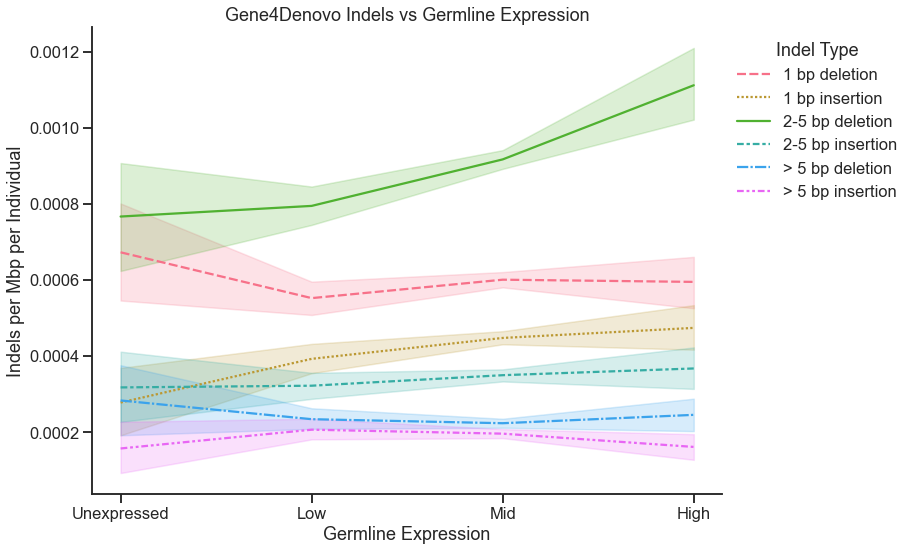

In [10]:
sns.set_style("ticks")
sns.set_context("talk")
fig, ax = plt.subplots(figsize=(13, 8))
sns.lineplot(
    ax=ax,
    data=resampled_exp_broad,
    y='per_Mbp_per_individual',
    hue='Simple_Categorization',
    x='Expr_Group_Broad_int',
    style='Simple_Categorization',
    style_order=['2-5 bp deletion', '1 bp deletion',  '1 bp insertion',
                 '2-5 bp insertion', '> 5 bp deletion', '> 5 bp insertion'],
    ci=None,
    palette='husl')
sns.despine()

hpal = sns.color_palette('husl', 6)
i = 0
for scat in resampled_exp_broad.Simple_Categorization.unique():
    tmp_df = resampled_exp_broad[resampled_exp_broad.Simple_Categorization == scat]
    ci_lo = tmp_df.groupby(['Expr_Group_Broad_int'])['per_Mbp_per_individual'].quantile(.025)
    ci_hi = tmp_df.groupby(['Expr_Group_Broad_int'])['per_Mbp_per_individual'].quantile(.975)
    ax.fill_between(ci_hi.index,
                    ci_lo,
                    ci_hi,
                    color=hpal[i],
                    alpha=0.2)
    i += 1
ax.xaxis.set_ticks(np.arange(0, 4, 1))
ax.set_xticklabels(broad_exp_order)

ax.legend(title='Indel Type', bbox_to_anchor=(1.0, 1.00), frameon=False)
plt.ylabel("Indels per Mbp per Individual")
plt.xlabel("Germline Expression")
hnd, lbls = ax.get_legend_handles_labels()
ax.set_title("Gene4Denovo Indels vs Germline Expression")
plt.tight_layout()
plt.savefig(
    os.path.join(
        out_dir,
        "gene4denovo_indels_bootstrapped_vs_germline_expression.pdf"))

## Bootstrap analysis by gene

In [8]:
from sklearn.utils import resample
from itertools import groupby
from collections import defaultdict

all_symbols = list(bed_df.Symbol.unique())
resampled_by_gene_exp_broad = pd.DataFrame()
for i in range(100):
    if i == 0:
        print("Iteration {}...".format(i + 1), end='')
    else:
        print("{}...".format(i + 1), end='')
    tmp_symbols = resample(all_symbols, replace=True)
    # create a dict of no. occurences vs list of gene names
    # i.e. {1: [gene1, gene2], 2: [gene3, gene4]...}
    tmp_symbols.sort()  # must be sorted for groupby to work
    counts2symbols = defaultdict(list)
    for symb, count in groupby(tmp_symbols):
        counts2symbols[len(list(count))].append(symb)
    sampled_df = pd.DataFrame()
    smpl_lengths = defaultdict(int)
    for i, symlist in counts2symbols.items():
        symset = set(symlist)
        mask = indel_df.Symbol.apply(
            lambda x: bool(set(str(x).split(';')).intersection(symset)))
        ith_df = indel_df[mask]
        sampled_df = sampled_df.append([ith_df] * i, ignore_index=True)
        # get length for each category for this gene set
        ith_smpl_lengths = bed_length_by_category(
            bed_df[bed_df.Symbol.isin(symset)],
            'Expr_Group_Broad',
            ['High', 'Mid', 'Low', 'Unexpressed'],
            mask_df=bed_df,
            quiet=True)
        # multiply lengths by number of times each gene appears in sample
        for k, v in ith_smpl_lengths.items():
            smpl_lengths[k] += v * i
    tmp_cat_vs_expr = df_to_group_counts(sampled_df,
                                         ['Expr_Group_Broad',
                                          'Simple_Categorization']) 
    tmp_cat_vs_expr['per_Mbp'] = tmp_cat_vs_expr.apply(
        lambda x: 1e6 * x.Count/smpl_lengths[x.Expr_Group_Broad],
        axis=1)
    resampled_by_gene_exp_broad = resampled_by_gene_exp_broad.append(
        tmp_cat_vs_expr)
print("\nFinished bootstraps")
broad_exp_order = ['Unexpressed', 'Low', 'Mid', 'High']
resampled_by_gene_exp_broad['Expr_Group_Broad_int'] = \
    resampled_by_gene_exp_broad.Expr_Group_Broad.apply(
            lambda x: broad_exp_order.index(x))
resampled_by_gene_exp_broad['per_Mbp_per_individual'] = resampled_by_gene_exp_broad.per_Mbp / n_individuals
resampled_by_gene_exp_broad.to_csv(
    os.path.join(
        out_dir,
        "gene4denovo_genes_bootstrapped_vs_germline_expression.csv"),
    index=False)
resampled_by_gene_exp_broad

Iteration 1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...58...59...60...61...62...63...64...65...66...67...68...69...70...71...72...73...74...75...76...77...78...79...80...81...82...83...84...85...86...87...88...89...90...91...92...93...94...95...96...97...98...99...100...
Finished bootstraps


Expr_Group_Broad Simple_Categorization  Count   per_Mbp  \
0              High         1 bp deletion    337  3.203338   
1              High        1 bp insertion    285  2.709055   
2              High       2-5 bp deletion    625  5.940909   
3              High      2-5 bp insertion    212  2.015156   
4              High       > 5 bp deletion    147  1.397302   
..              ...                   ...    ...       ...   
19      Unexpressed        1 bp insertion     32  1.257960   
20      Unexpressed       2-5 bp deletion     94  3.695258   
21      Unexpressed      2-5 bp insertion     41  1.611762   
22      Unexpressed       > 5 bp deletion     42  1.651073   
23      Unexpressed      > 5 bp insertion     13  0.511046   

    Expr_Group_Broad_int  per_Mbp_per_individual  
0                      3                0.000591  
1                      3                0.000500  
2                      3                0.001097  
3                      3                0.000372  
4                      3                0.000258  
..                   ...                     ...  
19                     0                0.000232  
20                     0                0.000682  
21                     0                0.000297  
22                     0                0.000305  
23                     0                0.000094  

[2400 rows x 6 columns]

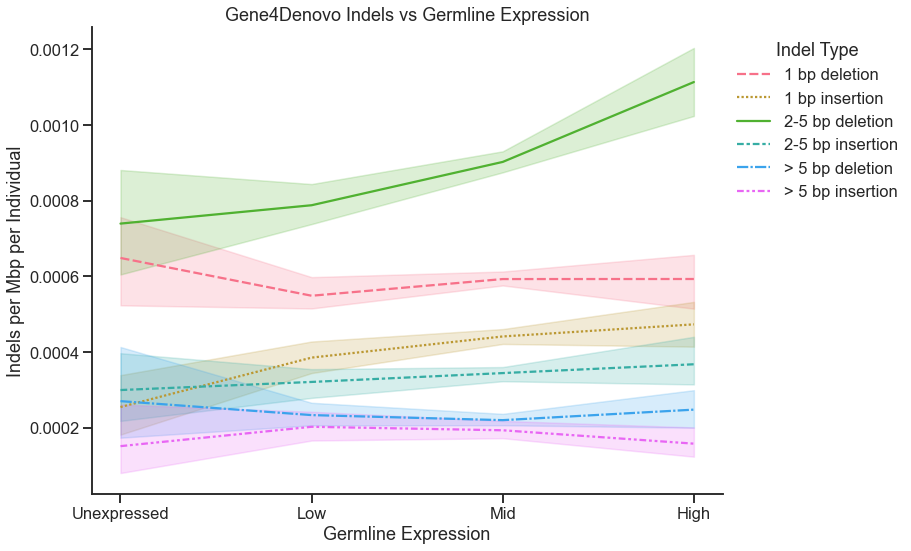

In [9]:
sns.set_style("ticks")
sns.set_context("talk")
fig, ax = plt.subplots(figsize=(13, 8))
sns.lineplot(
    ax=ax,
    data=resampled_by_gene_exp_broad,
    y='per_Mbp_per_individual',
    hue='Simple_Categorization',
    x='Expr_Group_Broad_int',
    style='Simple_Categorization',
    style_order=['2-5 bp deletion', '1 bp deletion',  '1 bp insertion',
                 '2-5 bp insertion', '> 5 bp deletion', '> 5 bp insertion'],
    ci=None,
    palette='husl')
sns.despine()

hpal = sns.color_palette('husl', 6)
i = 0
for scat in resampled_by_gene_exp_broad.Simple_Categorization.unique():
    tmp_df = resampled_by_gene_exp_broad[resampled_by_gene_exp_broad.Simple_Categorization == scat]
    ci_lo = tmp_df.groupby(['Expr_Group_Broad_int'])['per_Mbp_per_individual'].quantile(.025)
    ci_hi = tmp_df.groupby(['Expr_Group_Broad_int'])['per_Mbp_per_individual'].quantile(.975)
    ax.fill_between(ci_hi.index,
                    ci_lo,
                    ci_hi,
                    color=hpal[i],
                    alpha=0.2)
    i += 1

ax.xaxis.set_ticks(np.arange(0, 4, 1))
ax.set_xticklabels(broad_exp_order)

ax.legend(title='Indel Type', bbox_to_anchor=(1.0, 1.00), frameon=False)
plt.ylabel("Indels per Mbp per Individual")
plt.xlabel("Germline Expression")
hnd, lbls = ax.get_legend_handles_labels()
ax.set_title("Gene4Denovo Indels vs Germline Expression")
plt.tight_layout()
plt.savefig(
    os.path.join(
        out_dir,
        "gene4denovo_genes_bootstrapped_vs_germline_expression.pdf"))

## Bootstrap analysis of T(N)<sub>n</sub>T compliant deletions

In [14]:
from utils.utils import tnt_compliance_from_row


g4d_deletions = indel_df[(indel_df.variant_type == 'Del')].copy()
g4d_deletions['TNT_compliant'] = g4d_deletions.apply(tnt_compliance_from_row,
                                                     axis=1)
g4d_deletions.head()

chrom        pos  qual    ref alt  n_alleles variant_type repeat_type  \
0     1  217847741   NaN   TAGG   T          2          Del     Perfect   
1     2  164875949   NaN  TTTTA   T          2          Del     Perfect   
2    11  106845486   NaN  CAGAG   C          2          Del     Perfect   
3     4   91938901   NaN     TC   T          2          Del   No repeat   
5     3    3858098   NaN     CA   C          2          Del     Perfect   

  repeat_unit  repeat_length  ... cosmic_class  transcribed  \
0         AGG              9  ...    3:Del:R:2         True   
1        TTTA              8  ...    4:Del:R:1         True   
2        AGAG              8  ...    4:Del:R:1         True   
3         NaN              0  ...    1:Del:C:0         True   
5           A              4  ...    1:Del:T:3         True   

  transcribed_strand  Simple_Categorization   Symbol          Ensgene Strand  \
0              Sense        2-5 bp deletion  SPATA17  ENSG00000162814      +   
1          Antisense        2-5 bp deletion      NaN              NaN    NaN   
2          Antisense        2-5 bp deletion  GUCY1A2  ENSG00000152402      -   
3              Sense          1 bp deletion   CCSER1  ENSG00000184305      +   
5          Ambiguous          1 bp deletion    SUMF1  ENSG00000144455      -   

  Expression_Group Expr_Group_Broad  TNT_compliant  
0              7.0             High           True  
1              NaN              NaN           True  
2              4.0              Mid           True  
3              6.0              Mid          False  
5              5.0              Mid           True  

[5 rows x 22 columns]

In [15]:
resampled_tnt_exp = pd.DataFrame()
for i in range(1000):
    if i == 0:
        print("Iteration {}...".format(i + 1), end='')
    elif i % 100 == 0:
        print("{}...".format(i + 1), end='')
    tmp_df = resample(g4d_deletions, replace=True)
    tmp_cat_vs_expr = df_to_group_counts(
        tmp_df,
        ['Expr_Group_Broad', 'TNT_compliant'])
    tmp_cat_vs_expr['per_Mbp'] = tmp_cat_vs_expr.apply(
        lambda x: 1e6 * x.Count/expr2gene_length[x.Expr_Group_Broad],
        axis=1)
    resampled_tnt_exp = resampled_tnt_exp.append(tmp_cat_vs_expr)
broad_exp_order = ['Unexpressed', 'Low', 'Mid', 'High']
resampled_tnt_exp['Expr_Group_Broad_int'] = \
    resampled_tnt_exp.Expr_Group_Broad.apply(
            lambda x: broad_exp_order.index(x))
n_individuals = 5418
resampled_tnt_exp['per_Mbp_per_individual'] = resampled_tnt_exp.per_Mbp / n_individuals
resampled_tnt_exp.head()

Iteration 1...101...201...301...401...501...601...701...801...901...

Expr_Group_Broad  TNT_compliant  Count   per_Mbp  Expr_Group_Broad_int  \
0             High          False    341  3.663493                     3   
1             High           True    681  7.316243                     3   
2              Low          False    545  2.807086                     1   
3              Low           True   1152  5.933510                     1   
4              Mid          False   3120  3.250662                     2   

   per_Mbp_per_individual  
0                0.000676  
1                0.001350  
2                0.000518  
3                0.001095  
4                0.000600

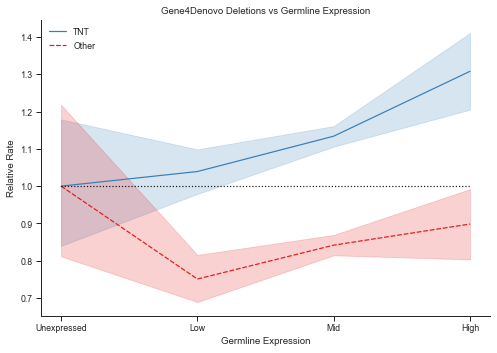

In [16]:
unexp_rates = resampled_tnt_exp[resampled_tnt_exp.Expr_Group_Broad == 'Unexpressed'].groupby(
    'TNT_compliant')['per_Mbp'].mean().to_dict()
unexp_rates
resampled_tnt_exp['Relative Rate'] = resampled_tnt_exp.apply(   
     lambda x: x.per_Mbp / unexp_rates[x['TNT_compliant']],
     axis=1)
sns.set_style("ticks")
sns.set_context("paper")
fig, ax = plt.subplots(figsize=(7, 5))
pal = sns.color_palette('Set1', 2)[::-1]
sns.lineplot(
    ax=ax,
    data=resampled_tnt_exp,
    y='Relative Rate',
    hue='TNT_compliant',
    hue_order=[True, False],
    x='Expr_Group_Broad_int',
    style='TNT_compliant',
    style_order=[True, False],
    ci=None,
    palette=pal)
sns.despine()

i = 0
for scat in [True, False]:
    tmp_df = resampled_tnt_exp[resampled_tnt_exp.TNT_compliant == scat]
    ci_lo = tmp_df.groupby(['Expr_Group_Broad_int'])['Relative Rate'].quantile(.025)
    ci_hi = tmp_df.groupby(['Expr_Group_Broad_int'])['Relative Rate'].quantile(.975)
    ax.fill_between(ci_hi.index,
                    ci_lo,
                    ci_hi,
                    color=pal[i],
                    alpha=0.2)
    i += 1
ax.xaxis.set_ticks(np.arange(0, 4, 1))
ax.set_xticklabels(broad_exp_order)
ax.plot([0, 3], [1, 1], ':', c='k', alpha=0.9)
hnd, lbls = ax.get_legend_handles_labels()
ax.legend(labels=['TNT', 'Other'], loc='upper left', frameon=False)
plt.xlabel("Germline Expression")
ax.set_title("Gene4Denovo Deletions vs Germline Expression")
plt.tight_layout()
plt.savefig(
    "outputs/dnm_germline_expression//gene4denovo_tnt_bootstrapped_vs_germline_expression.pdf")
resampled_tnt_exp.to_csv(
    "outputs/dnm_germline_expression/gene4denovo_tnt_bootstrapped_vs_germline_expression.csv",
    index=False)